# Forecasting Methods

- How can we make predictions?


| method | description |
|--------|-------------|
| linear regression | fits a linear model to the entire data |
| exponential smoothing | only the last N data points |
| Kalman filter | detects whether the trend is changing |
| ARIMA | combination of autoregressive (AR) and moving average (MA) |
| Prophet library | black-box model to generate forecasts quickly |
| Churn Prediction | classification whether a customer will be lost |

### Forecasting models that we won't cover:

#### Look at past patterns or data and try and make a prediction

- We could take some kind of function, and fit it somehow.
- Decompose and analyse the data
- Perform Linear Regression - making naive assumption that it is linear

#### Naive methods:
- Take the mean - or take the mean over the last 10 periods 
- Take value at t-1 - i.e. predict what it is today!

#### Complex models:
- **Exponential smoothing - we won't talk about this today
- **Neural network** (in particular an LSTM)
- **Kalman filter** (most common in process control) - used to detect if there is a change in trend, not made for forecasting

### Forecasting methods we will cover:

- **ARIMA model!** - combination of Autoregressive (AR) and moving average (MA)
- **FB Prophet** - black-box model to generate forecasts quickly


## ARIMA
- Get a Time Series to analyze

In [1]:
import seaborn as sns
import pandas as pd
from matplotlib import pyplot as plt
%matplotlib inline

df = sns.load_dataset('flights')

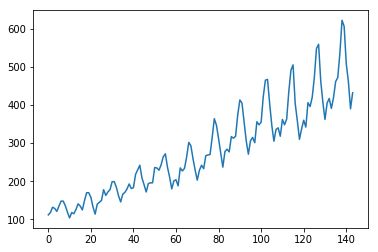

In [2]:
df['passengers'].plot()

### Bare in mind, ARIMA models require the data to be:

1. **Non-seasonal**
2. **Non-trendy**

- When using an ARIMA model we need to establish there is no trend and no seasonality. For that we use Autocorrelation!


- **We want to exclude autocorrelation** - we call a non-autocorrelated time series **stationary**!

### Autocorrelation
- correlation for each time shift --> ACF plot

This sort of analysis can be done to establish if there is seasonality or trend!

In [3]:
y = df['passengers']

In [4]:
df['p1'] = df['passengers'].shift(1)
df['p2'] = df['passengers'].shift(2)
df['p3'] = df['passengers'].shift(3)
df['p4'] = df['passengers'].shift(4)
df['p5'] = df['passengers'].shift(5)

In [5]:
df.head()

,year,month,passengers,p1,p2,p3,p4,p5
0,1949,January,112,NaN,NaN,NaN,NaN,NaN
1,1949,February,118,112.0,NaN,NaN,NaN,NaN
2,1949,March,132,118.0,112.0,NaN,NaN,NaN
3,1949,April,129,132.0,118.0,112.0,NaN,NaN
4,1949,May,121,129.0,132.0,118.0,112.0,NaN


In [6]:
# correlate the lags

df[['passengers', 'p1']].corr() # here there is correlation

,passengers,p1
passengers,1.000000,0.960195
p1,0.960195,1.000000


In [7]:
df[['passengers', 'p1', 'p2']].corr() 
# Now we can see that there is less correlation
# but it is still there

,passengers,p1,p2
passengers,1.000000,0.960195,0.895675
p1,0.960195,1.000000,0.960249
p2,0.895675,0.960249,1.000000


#### If there is correlation, we could eventually establish there IS seasonality or THERE IS TREND!

In [8]:
df[['passengers', 'p1', 'p2','p3','p4','p5']].corr()

,passengers,p1,p2,p3,p4,p5
passengers,1.000000,0.960195,0.895675,0.837395,0.797735,0.785943
p1,0.960195,1.000000,0.960249,0.894473,0.836002,0.799965
p2,0.895675,0.960249,1.000000,0.961133,0.896597,0.844427
p3,0.837395,0.894473,0.961133,1.000000,0.960920,0.899075
p4,0.797735,0.836002,0.896597,0.960920,1.000000,0.962171
p5,0.785943,0.799965,0.844427,0.899075,0.962171,1.000000


## Statsmodels 
- Statsmodels has a convenient function to check if it's autocorrelated!

- Calculates the autocorrelation for all legs: p1, p2, ..., up to pN

In [9]:
from statsmodels.tsa.stattools import acf

autocorr = acf(df['passengers'])

#### - if the ACF plot drops quickly to near-zero, you have neither a trend nor seasonality

<BarContainer object of 41 artists>

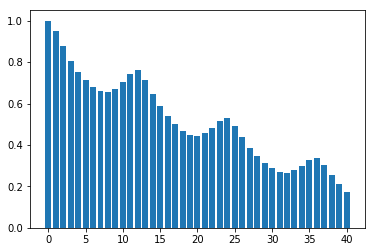

In [11]:
autocorr = acf(df['passengers'])

plt.bar(range(len(autocorr)), autocorr)

- We have here the **autocorrelation for all the different lags** - from here we can see there's **plenty of autocorrelation** going on!

**If it was stationary, it would drop to 0 over 2 or 3 periods!**

We see **evidence of seasonality here** too - every 12 months! We see **seasonality over a year**!

##### THEREFORE, WE CANNOT USE THIS DATA TO BUILD AN ARIMA MODEL!!!


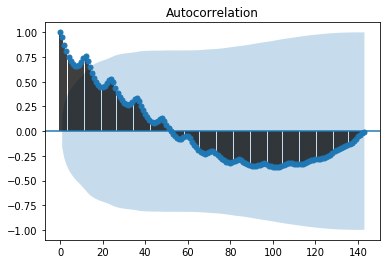

In [12]:
from statsmodels.graphics.tsaplots import plot_acf

plot_acf(df['passengers'])
None

- This does the same, but plots more lags!

- At some point it becomes a negative autocorrelation

**Shaded blue area is a confidence interval** where you have a **significant threshold**

- If our values are outside of the blue area we can be sure we have significant autocorrelation!

**Only enters blue area after 15 periods!** So we have autocorrelation and we **cannot use the ARIMA model** here!

**To use the ARIMA model we should have all the points in this blue shaded area!**

### Couterexample: Random Data

In [10]:
import random

In [13]:
ry = [random.random() for i in range(1000)]

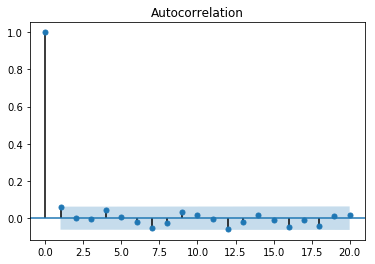

In [14]:
plot_acf(ry, lags=20)
None

#### With random data, we don't have autocorrelation by definition! Otherwise it wouldn't be random!!

### Random Walk

- It is a special type of time series, we do this to establish a concept to define time series, especially in financial data

e.g. stock price changing and you have no way to describe the pattern - that's a random walk

- So the value in the next period equals value at t-1 + random

We don't have much data other than the value of the days before

- value(t) = value (t-1) + random

Let's make our own random walk:

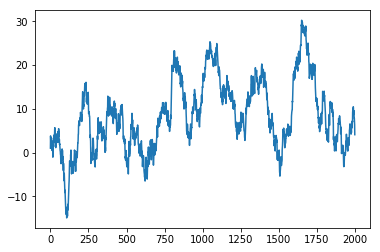

In [15]:
# ry = [random.random() for i in range(1000)] becomes this: (for 200 now not 1000)

walk = [1.0]
for i in range (2000):
    
    r = random.gauss(0.0, 1.0) # Needs two parameters - mean and stdev
    
    new_value = walk[-1] + r
    
    walk.append(new_value)
    
'''
in one line: for i in range (200):
                 walk.append(walk[-1] + random.gauss(0.0, 1.0))
                 
'''    
plt.plot(range(2001), walk)

- It's a  pretty good estimate - completely random pretty much too

### Autoregressive Model

- AR(p):

$y_t = c + w_1 y_{t-1} + w_2 y_{t-2} .. + w_p y_{t-p} + \epsilon_t$

We would have coefficients that we multiply by the lagged y values

There is an error term that is left in our autoregressive model - epsilon 

We have a hyperparameter p, which tells us how many periods we are looking into the past!

Try:
* c = 18, w1 = -0.8
* c = 8, w1 = 1.3, w2 = -0.7

In [16]:
# generate data (200 periods) using an AR(p) process

data = [0.0]

c = 18.0
w1 = -0.8

for i in range(200):
    
    yt = c + w1 * data[-1]  
    data.append(yt)

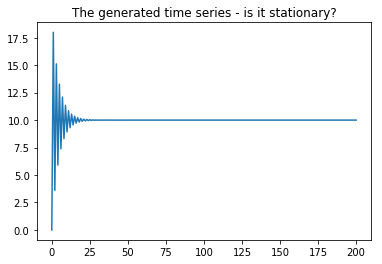

In [17]:
plt.plot(range(201), data)
plt.title('The generated time series - is it stationary?')
plt.show()

We could take this data and look at the autocorrelation:

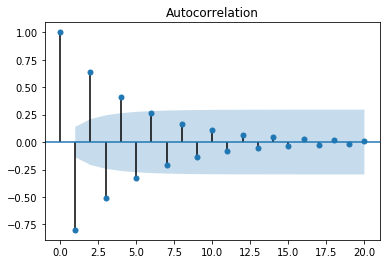

In [18]:
plot_acf(data, lags=20)
None

We're still seeing autocorrelation! It stays in significantly autocorrelated part for quite a while.

In [19]:
# We didn't include the error!

data = [0.0]

c = 18.0
w1 = -0.8

for i in range(200):
    
    yt = c + w1 * data[-1] + random.random()
    data.append(yt)

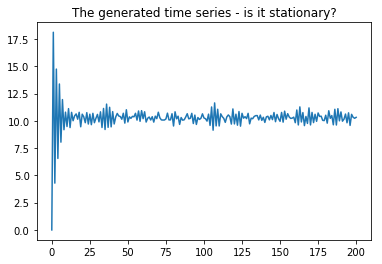

In [20]:
plt.plot(range(201), data)
plt.title('The generated time series - is it stationary?')
plt.show()

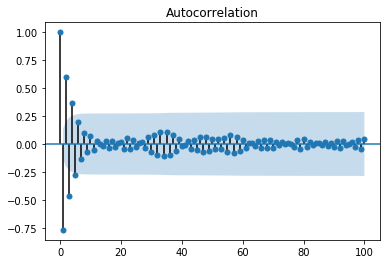

In [21]:
plot_acf(data, lags=100)
None

Now we change the starting point to get rid 

In [22]:
data = [10.0]

c = 18.0
w1 = -0.8

for i in range(200):
    
    yt = c + w1 * data[-1] + random.random()
    data.append(yt)

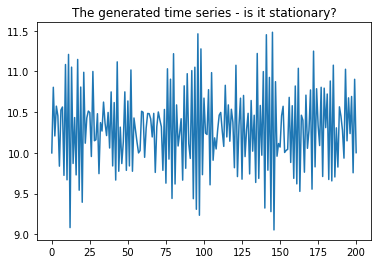

In [23]:
plt.plot(range(201), data)
plt.title('The generated time series - is it stationary?')
plt.show()

There is still some kind of pattern - but it is not seasonal.

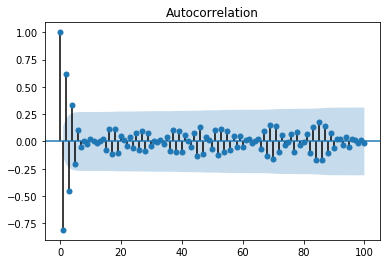

In [24]:
plot_acf(data, lags=100)
None

In [25]:
data = [12.5]

c = 18.0
w1 = -0.5

for i in range(200):
    
    yt = c + w1 * data[-1] + random.random()
    data.append(yt)

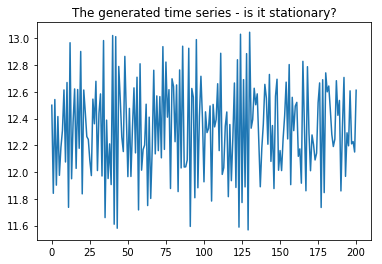

In [26]:
plt.plot(range(201), data)
plt.title('The generated time series - is it stationary?')
plt.show()

This is approximately what a stationary model looks like

### Initialize and fit an ARIMA model

In [27]:
from statsmodels.tsa.arima_model import ARIMA
import numpy as np

In [28]:
ytrain = data[:150] # different from what we did with scikit learn 
                 # with train_test_split - test set is always the last part
                 # of your data
ytest = data[150:]

In [29]:
# (ar, d, ma) <- Order of the ARIMA model (usually small numbers)

# ar - autoregressive part - how many periods you look into the past (0 to 3)
#  d - damping/integration coefficient (the I in ARIMA) (0 to 1)
# ma - moving average part - moving average of the residuals(or epsilons)(0 to 3)

# the higher these numbers, the more complex your model gets 
# they usually don't go past 3!

m = ARIMA(ytrain, (2, 1, 2)) # has 3 hyperparameters
    
m.initialize()
r = m.fit()

Statsmodels internally works out the coefficients etc

Generating a predicted score, an error, a confidence:

In [30]:
# prediction for future periods (xtest)

ypred, err, conf = r.forecast(steps=50)
ypred # prediction into the future

array([12.57547196, 12.21558429, 12.44738582, 12.2991468 , 12.39498168,
       12.33405091, 12.37380127, 12.34888611, 12.36550211, 12.35544367,
       12.3625169 , 12.35858694, 12.36172382, 12.36032189, 12.36183504,
       12.36147593, 12.36231929, 12.36239034, 12.36295742, 12.36320592,
       12.36365902, 12.36398072, 12.36438681, 12.3647387 , 12.3651254 ,
       12.36548975, 12.36586845, 12.36623793, 12.36661334, 12.36698494,
       12.36735898, 12.36773145, 12.36810494, 12.36847777, 12.36885102,
       12.369224  , 12.36959716, 12.3699702 , 12.37034332, 12.37071639,
       12.37108949, 12.37146257, 12.37183566, 12.37220875, 12.37258184,
       12.37295492, 12.37332801, 12.3737011 , 12.37407419, 12.37444727])

In [31]:
# prediction on the training data
r.fittedvalues.shape

# fittedvalues is the output of my model - it is what it has fitted
# equivalent to m.predict(xtrain) in scikit

(149,)

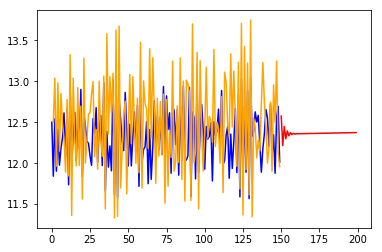

In [32]:
plt.plot(range(150), ytrain, color = 'blue')

plt.plot(range(1, 150), r.fittedvalues + 12.5, color = 'orange')

plt.plot(range(150,200), ypred, color = 'red')

Our ypred is clearly wrong, right?

### Let's try another example

Now we are building an AR(2) process - We're generating random data

$y_t = c + w_1 y_{t-1} + w_2 y_{t-2} .. + w_p y_{t-p} + \epsilon_t$

* c = 8, w1 = 1.3, w2 = -0.7

In [45]:
# Generate data (200 periods) using an AR(p) process

data = [12.5]
c = 8.0
w1 = 1.3
w2 = -0.7

for i in range(200):
    
    yt = c + w1 * data[-1] + w2 * data[-2] + random.gauss(0.0,1.0)
    data.append(yt)
    
    # Need to add an extra data point!

IndexError: list index out of range

In [47]:
random.seed(42) # Should fix the random distribution

data = [15, 15]
c = 8.0
w1 = 1.3
w2 = -0.7

# array([20.14228929,  1.35358323, -0.80076683])


for i in range(199):
    
    yt = c + w1 * data[-1] + w2 * data[-2] + random.gauss(0.0,1.0)
    data.append(yt)

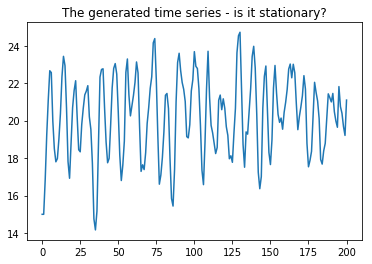

In [50]:
plt.plot(range(201), data)
plt.title('The generated time series - is it stationary?')
plt.show()

This starts to equilibrate around 10/15 so can change data points to 15

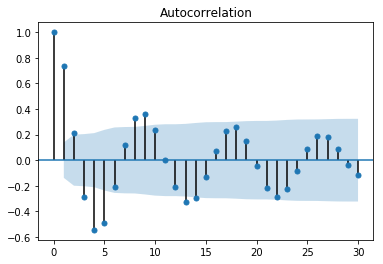

In [51]:
plot_acf(data, lags=30)
None

You would want 19 out of 20 points inside the blue shaded area to say there's no autocorrelation!

In [52]:
ytrain = data[:150] # different from what we did with scikit learn 
                 # with train_test_split - test set is always the last part
                 # of your data
ytest = data[150:]

In [53]:
# (ar, d, ma) <- Order of the ARIMA model (usually small numbers)

# ar - autoregressive part - how many periods you look into the past (0 to 3)
#  d - damping/integration coefficient (the I in ARIMA) (0 or 1)
# ma - moving average part - moving average of the residuals(or epsilons)(0 to 3)

m = ARIMA(ytrain, (2, 1, 2)) 
    
m.initialize()
r = m.fit()

In [54]:
# prediction for future periods (xtest)

ypred, err, conf = r.forecast(steps=50) # predict me 50 steps into the future
                 #that's actually quite a lot, usually 10 steps would be good
ypred.shape # prediction into the future

(50,)

In [55]:
r.params

# adding (2,0,2) adds more parameters

array([ 0.00526725,  1.38085286, -0.82364604, -1.08269122,  0.08269123])

In [56]:
# prediction on the training data
r.fittedvalues.shape

# fittedvalues is the output of my model - it is what it has fitted
# equivalent to m.predict(xtrain) in scikit

(149,)

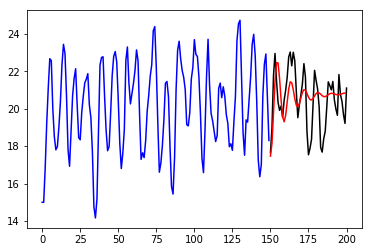

In [57]:
plt.plot(range(150), ytrain, color = 'blue')

plt.plot(range(150,201), ytest, color = 'black') # Not sure why 201 but fixed it!

plt.plot(range(150,200), ypred, color = 'red')

#### ARIMA does not allow for long term forecasts - quite good at the beginning 

## Re-train the ARIMA model to make 1-period forecasts

In [58]:
# We can

result = []
for x in range(150,200):
    ytrain = data[:x]
    m = ARIMA(ytrain, (2, 1, 2))
    m.initialize()
    r = m.fit()

# now predict 1 period at a time
    ypred, err, conf = r.forecast(steps=1)
    result.append(ypred[0])

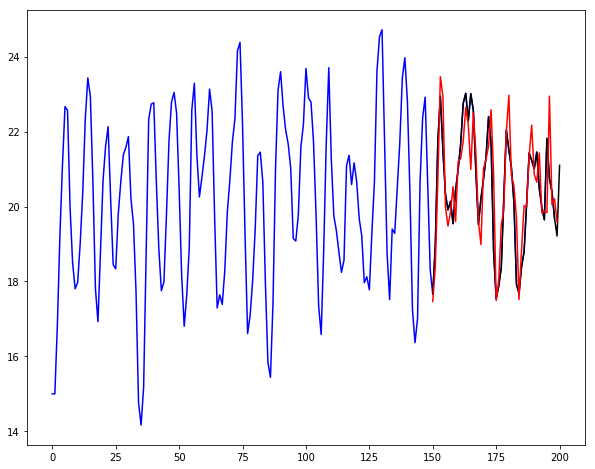

In [59]:
plt.figure(figsize=(10,8))

plt.plot(range(199), ytrain, color = 'blue')

plt.plot(range(150,201), ytest, color = 'black') # Not sure why 201 but fixed it!

plt.plot(range(150,200), result, color = 'red')

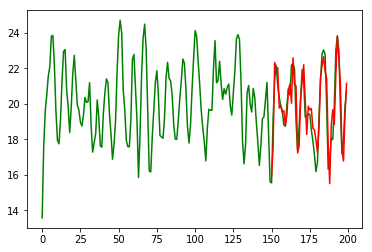

In [36]:
# plot again